# Lab Demonstration 1  
## Fractals with Tensorflow

### Vincent Abbosh /  45019218

In [1]:
import tensorflow as tf
tf.__version__

'1.13.1'

## Part 1

In [2]:
import numpy as np

sess = tf.InteractiveSession()

#### Producing a 2D Gaussian image

In [3]:
X, Y = np.mgrid[-4.0:4:0.01, -4.0:4:0.01]

In [4]:
xs = tf.constant(X.astype(np.float32))
ys = tf.constant(Y.astype(np.float32))

In [5]:
tf.global_variables_initializer().run() #init variables

In [6]:
zs = tf.exp(-(xs**2+ys**2)/2.0)

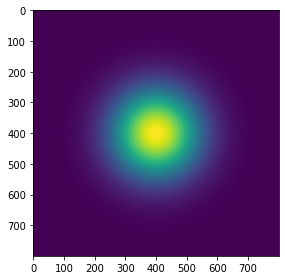

In [8]:
#plot
import matplotlib.pyplot as plt
plt.imshow(zs.eval())
plt.tight_layout()
plt.show()

#### Use $sin(x)$

In [9]:
zs_sin = tf.sin(xs**2 + ys**2)

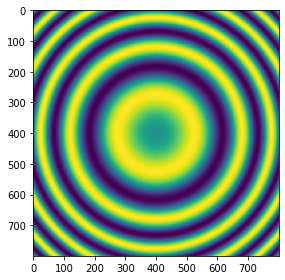

In [14]:
plt.imshow(zs_sin.eval())
plt.tight_layout()
plt.show()

### Plot $e^{-\frac{r^2}{\sigma}}sin(r^2)$

In [17]:
zs_prod = zs * zs_sin

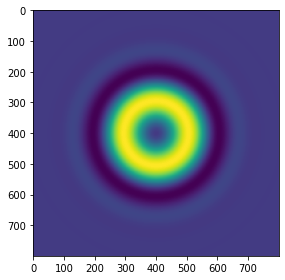

In [19]:
plt.imshow(zs_prod.eval())
plt.tight_layout()
plt.show()